In [209]:
import pandas as pd 
import geopandas as gpd
from scipy.io import mmread
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib

from sklearn.preprocessing import LabelEncoder

# Toronto 
## Cases

In [2]:
df_tor = pd.read_csv("Data/CasesToronto.csv")
#df_tor["Neighbourhood Name"].value_counts()
#df_tor.Outcome.value_counts()
df_tor.columns

Index(['_id', 'Assigned_ID', 'Outbreak Associated', 'Age Group',
       'Neighbourhood Name', 'FSA', 'Source of Infection', 'Classification',
       'Episode Date', 'Reported Date', 'Client Gender', 'Outcome',
       'Currently Hospitalized', 'Currently in ICU', 'Currently Intubated',
       'Ever Hospitalized', 'Ever in ICU', 'Ever Intubated'],
      dtype='object')

In [323]:
df_tor.shape

(16942, 18)

In [318]:
df_tor["Episode Date"] = pd.to_datetime(df_tor["Episode Date"])

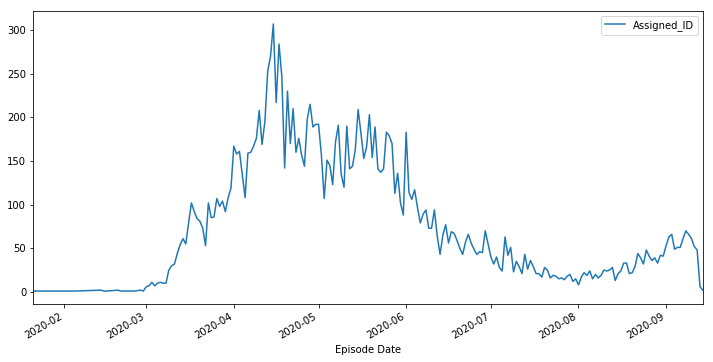

In [334]:
fig, ax = plt.subplots(1,1, figsize = (12, 6))
df_tor.groupby(["Episode Date"]).count().reset_index().plot(x = "Episode Date", y = "Assigned_ID", ax = ax )
fig.savefig("Data/cases.png")

## Traffic

In [138]:
file_name = "2019-04-14-Toronto"
traffic_toronto = gpd.read_file("Data/Traffic/"+file_name+".geojson")

In [139]:
traffic_toronto = traffic_toronto.iloc[1:]
traffic_toronto = traffic_toronto.drop(["jobName", "creationTime", "userPreference", "dateRanges", "timeSets", "networkName", "zoneId", "probeSource", "segmentId"], axis = 1)

substr_speed = "averageSpeed"
substr_sample_size = "sampleSize"
substr_avg_trav_t = "averageTravelTime"

traffic_toronto["avgSpeed"] = traffic_toronto.apply(lambda row: float(row.segmentTimeResults[row.segmentTimeResults.find(substr_speed) + 15: row.segmentTimeResults.find(substr_speed) +22]), axis = 1  )
traffic_toronto["sampleSize"] = traffic_toronto.apply(lambda row: int(row.segmentTimeResults[row.segmentTimeResults.find(substr_sample_size) + 13: row.segmentTimeResults.find(substr_avg_trav_t) -3]), axis = 1  )
traffic_toronto = traffic_toronto.drop(["segmentTimeResults"], axis = 1)
traffic_toronto.to_file("Data/Traffic/Final/shp/"+ file_name+ ".shp")

In [125]:
"""
fig, ax = plt.subplots(1, 1, figsize = (15,8))
traffic_toronto.plot(column = "sampleSize", ax = ax, linewidth=0.2 , legend = True, cmap = "coolwarm",
                    norm= matplotlib.colors.LogNorm(vmin=1, vmax=traffic_toronto.sampleSize.max()))
fig.savefig("Data/Toronto_Traffic_Density.png", dpi = 600)
""";

## Neighbourhood Profiles

In [116]:
DF_neighbourhoods_info = pd.read_csv("Data/neighbourhood-profiles-2016-csv.csv")
DF_neighbourhoods_info.head()

,_id,Category,Topic,Data Source,Characteristic,City of Toronto,Agincourt North,Agincourt South-Malvern West,Alderwood,Annex,...,Willowdale West,Willowridge-Martingrove-Richview,Woburn,Woodbine Corridor,Woodbine-Lumsden,Wychwood,Yonge-Eglinton,Yonge-St.Clair,York University Heights,Yorkdale-Glen Park
0,1,Neighbourhood Information,Neighbourhood Information,City of Toronto,Neighbourhood Number,NaN,129,128,20,95,...,37,7,137,64,60,94,100,97,27,31
1,2,Neighbourhood Information,Neighbourhood Information,City of Toronto,TSNS2020 Designation,NaN,No Designation,No Designation,No Designation,No Designation,...,No Designation,No Designation,NIA,No Designation,No Designation,No Designation,No Designation,No Designation,NIA,Emerging Neighbourhood
2,3,Population,Population and dwellings,Census Profile 98-316-X2016001,"Population, 2016","2,731,571","29,113","23,757","12,054","30,526",...,"16,936","22,156","53,485","12,541","7,865","14,349","11,817","12,528","27,593","14,804"
3,4,Population,Population and dwellings,Census Profile 98-316-X2016001,"Population, 2011","2,615,060","30,279","21,988","11,904","29,177",...,"15,004","21,343","53,350","11,703","7,826","13,986","10,578","11,652","27,713","14,687"
4,5,Population,Population and dwellings,Census Profile 98-316-X2016001,Population Change 2011-2016,4.50%,-3.90%,8.00%,1.30%,4.60%,...,12.90%,3.80%,0.30%,7.20%,0.50%,2.60%,11.70%,7.50%,-0.40%,0.80%


**We should choose a subset of the effective number of neighbourhoods**

In [300]:
DF_neighbourhoods_shape = gpd.read_file("Data/toronto_neigh.geojson")
DF_neighbourhoods_shape["AREA_S_CD"] = DF_neighbourhoods_shape["AREA_S_CD"].astype("int32") 
DF_neighbourhoods_shape = DF_neighbourhoods_shape.sort_values(by = ["AREA_S_CD"]).reset_index().drop(["index"], axis = 1)

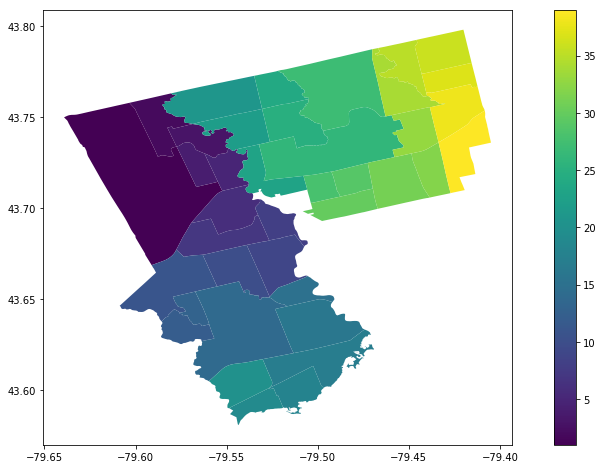

In [302]:
fig, ax = plt.subplots(1, 1, figsize = (15,8))
DF_neighbourhoods_shape.loc[:38,:].plot(column = "AREA_S_CD", ax =ax, cmap = "viridis", legend = True)

## OSM Data

In [119]:
# http://polygons.openstreetmap.fr/index.py?id=43992 , polygon creation from osm id (turin = 43992)
boundary_toronto = gpd.read_file("Data/Toronto.geojson")
#bbox = boundary_turin.envelope 
#df_bbox = gpd.GeoDataFrame(gpd.GeoSeries(bbox), columns = ["geometry"])
#intersections = gpd.overlay(df_bbox, DF_roads_turin, how = "intersection")

In [120]:
# bbox = (7.25,44.8,8.1,45.4)
DF_roads_toronto = gpd.read_file("Data/ontario-latest-free.shp/gis_osm_roads_free_1.shp", bbox = boundary_toronto)
DF_buildings_toronto = gpd.read_file("Data/ontario-latest-free.shp/gis_osm_buildings_a_free_1.shp", bbox = boundary_toronto)
# ferrovie di treni e tram
DF_railway_toronto = gpd.read_file("Data/ontario-latest-free.shp/gis_osm_railways_free_1.shp", bbox = boundary_toronto)
#parcheggi, anche multipiano
DF_parking_toronto = gpd.read_file("Data/ontario-latest-free.shp/gis_osm_traffic_a_free_1.shp", bbox = boundary_toronto)

# just in case
DF_churches_toronto = gpd.read_file("Data/ontario-latest-free.shp/gis_osm_pofw_a_free_1.shp", bbox = boundary_toronto)
# ospedali, parchi, teatri 
DF_public_places_toronto = gpd.read_file("Data/ontario-latest-free.shp/gis_osm_pois_a_free_1.shp", bbox = boundary_toronto)
# DF_public_places_toronto[DF_public_places_toronto.fclass == "hospital"]
# stazioni ferroviarie, fermate bus, tram, traghetto (lol?), taxi 
DF_transport_toronto = gpd.read_file("Data/ontario-latest-free.shp/gis_osm_transport_a_free_1.shp", bbox = boundary_toronto)

In [121]:
DF_roads_toronto.to_file("Data/Toronto_final/Roads_Toronto.shp")
DF_buildings_toronto.to_file("Data/Toronto_final/Buildings_Toronto.shp")

In [122]:
DF_public_places_toronto[DF_public_places_toronto.fclass == "hospital"].to_file("Data/Toronto_final/Hospitals_toronto.shp")

In [123]:
print(DF_roads_toronto.shape)
print(DF_buildings_toronto.shape)
print(DF_railway_toronto.shape)
print(DF_parking_toronto.shape)

(134309, 11)
(504997, 6)
(4256, 8)
(15743, 5)


In [142]:
"""
# matplotlib qt permette di avere una figura interattiva
# %matplotlib qt

#%matplotlib inline

fig, ax = plt.subplots(figsize=(20, 20))
DF_roads_toronto.plot(ax = ax, alpha = 0.4, color = "black")
DF_buildings_toronto.plot(ax = ax, alpha = 0.8, color = "orange")
DF_public_places_toronto.plot(ax = ax , alpha = 0.6, color = "pink")
DF_parking_toronto.plot(ax = ax, alpha = 0.7, color = "blue")
DF_churches_toronto.plot(ax = ax, alpha = 0.7, color = "green")
DF_railway_toronto.plot(ax = ax, alpha = 0.4, color = "red")
#fig.savefig("Data/Toronto_Net.png", dpi = 1200)
""";

## [3D Massing Data](https://ckan0.cf.opendata.inter.prod-toronto.ca/tl/dataset/3d-massing)

In [150]:
height_buildings = gpd.read_file("Data/Buildings/3DMassingShapefile_2019_WGS84/3DMassing_2019_WGS84.shp")

In [154]:
height_buildings.head()

,MIN_HEIGHT,MAX_HEIGHT,AVG_HEIGHT,HEIGHT_MSL,SURF_ELEV,HEIGHT_SRC,BLDG_SRC,LONGITUDE,LATITUDE,POLY_AREA,PERIMETER,geometry
0,0.0,9.3506,7.3090,165.570,158.260969,Lidar-Derived,Photogrammetrics,-79.592266,43.660304,1906.173775,180.218234,"POLYGON Z ((-8860176.220 5412977.925 0.000, -8..."
1,0.0,12.8670,8.2040,164.810,156.605735,Lidar-Derived,Photogrammetrics,-79.588970,43.663573,1434.416417,220.001068,"POLYGON Z ((-8859825.993 5413524.684 0.000, -8..."
2,0.0,7.6432,4.1913,160.644,156.452207,Lidar-Derived,Photogrammetrics,-79.588479,43.664104,612.515578,111.077719,"POLYGON Z ((-8859772.590 5413596.135 0.000, -8..."
3,0.0,8.0415,4.8489,159.575,154.725699,Lidar-Derived,Photogrammetrics,-79.583894,43.660113,413.462391,89.451738,"POLYGON Z ((-8859259.827 5412997.345 0.000, -8..."
4,0.0,9.1097,5.9776,161.652,155.674130,Lidar-Derived,Photogrammetrics,-79.584291,43.658825,263.809671,68.827410,"POLYGON Z ((-8859298.506 5412800.913 0.000, -8..."


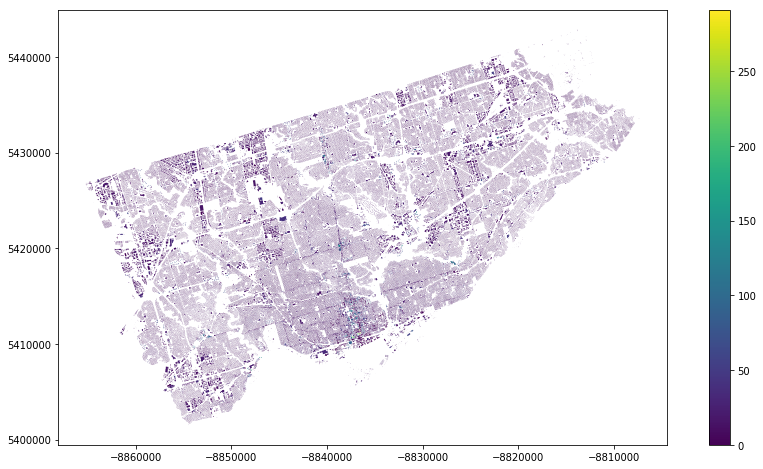

In [156]:
"""fig, ax = plt.subplots(1, 1, figsize = (15,8))
height_buildings.plot(column = "MAX_HEIGHT", ax = ax, linewidth=0.2 , legend = True, cmap = "viridis",
                    vmin=height_buildings.MAX_HEIGHT.min(), vmax=height_buildings.MAX_HEIGHT.max())
fig.savefig("Data/Buildings_Height.png", dpi = 600)
"""

## [Zoning By Law](https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/zoning-by-law)

Ref: https://www.toronto.ca/wp-content/uploads/2017/10/9706-City-Planning-Zoning-city-wide-zoning-map.pdf

In [269]:
zoning = gpd.read_file("Data/Buildings/ZoningByLaw/ZONING_ZONE_CATAGORIES_WGS84.shp")

In [270]:
# There are some NaN values, replace them with "UNASSIGNED" zone category - which is OK 
zoning["ZN_ZONE"] = zoning["ZN_ZONE"].fillna("UNASSIGNED")
zoning["ZN_ZONE"] = zoning["ZN_ZONE"].replace("TBD","UNASSIGNED")
#zoning["ZN_ZONE"] = zoning["ZN_ZONE"].replace(None,"UNASSIGNED")
# Encoding Zone categories, so that we have numbers and not strings, for plotting purposes
zoning["ZONE_LABEL"]  = LabelEncoder().fit_transform(zoning["ZN_ZONE"].astype(str))

### Explaining ZN_ZONE
zones_dict = {"R": "Residential", "RD":"Residential Detached", "RA": "Residential Apartment",
              "CR": "Commercial Residential" , "E":"Employment Industrial", "CRE":"Commercial Residential Employment",
               "O":"Open Space", "CL":"Commercial Local","OR":"Open Space Recreation","ON":"Open Space Natural",
              "RM":"Residential Multiple Dwelling","RAC":"Residential Apartment Commercial","IPW":"Institutional Place of Worship",
              "EL":"Employment Light Industrial", "RS":"Residential Semi Detached", "RT":"Residential Townhouse", "EH":"Employment Heavy Industrial",
             "UNASSIGNED":"UNKNOWN", "I": "Institutional General", "EO":"Employment Industrial Office", "OC":"Open Space Cemetery",
             "IS":"Institutional School", "IH":"Institutional Hospital", "UT" : "Utility and Transportation", 
              "IE":"Institutional Education", "U":"Utility", "OG" : "Open Space Golf Course", "OM":"Open Space Marina",
              "EC":"Employment Industrial Commercial" }

zoning["ZN_ZONE_EXT"] = zoning.ZN_ZONE.replace(zones_dict)

## Filtering useful columns for GAMA
zoning = zoning.loc[:, zoning.columns.intersection(['OBJECTID','ZN_ZONE', 'geometry', 'ZONE_LABEL', 'ZN_ZONE_EXT'])]

In [279]:
#zoning[zoning["ZN_ZONE_EXT"] == "Utility and Transportation"].plot()

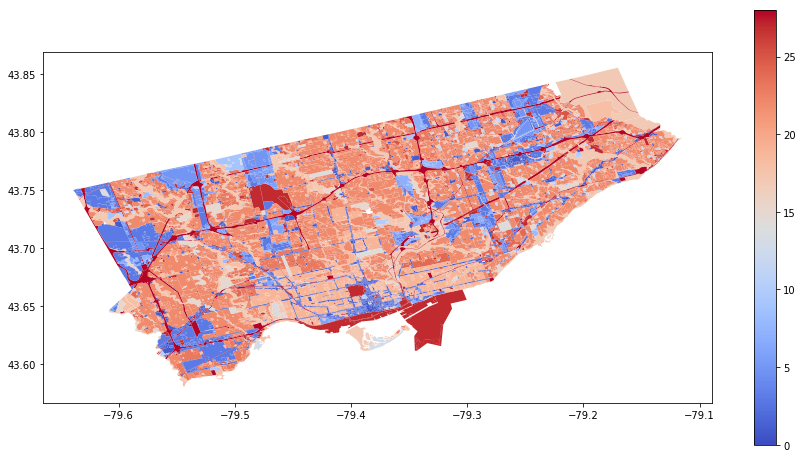

In [272]:
fig, ax = plt.subplots(1, 1, figsize = (15,8))
zoning.plot(column = "ZONE_LABEL", ax = ax, cmap = "coolwarm", legend = True)
#fig.savefig("Data/toronto_zones.png", dpi = 1200)